In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append(os.path.abspath(".."))
import models_mae


/home/abujalancegome/.conda/envs/mae3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

torch.Size([12, 1000])


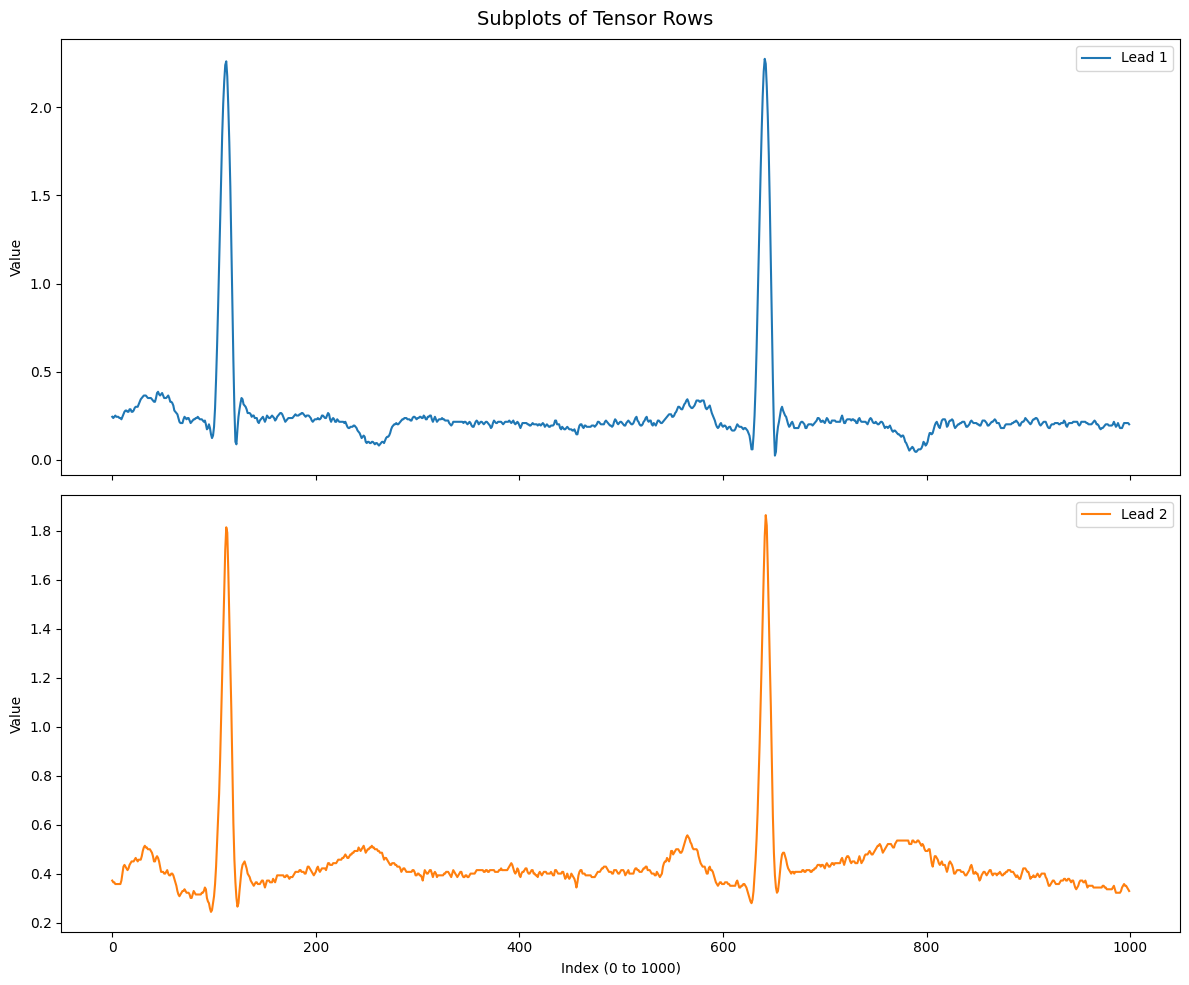

In [3]:
tensor_path = "/home/abujalancegome/deep_risk/data/ECG_leads_full_pretraining_train.pt"

tensor = torch.load(tensor_path)[3,:,:,:1000].squeeze(1)
print(tensor.shape)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

for i in range(2):
    axes[i].plot(tensor[i].numpy(), label=f"Lead {i+1}", color="C" + str(i))
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")

axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

In [4]:
# chkpt_dir = 'mae_visualize_vit_large.pth'
chkpt_model = "/home/abujalancegome/deep_risk/mae/pretrain_mae/lr_1e-4_wd_1e-4_mr_0.7/checkpoint-9-loss-0.6338.pth"
# model_mae = prepare_model(chkpt_model, 'mae_vit_base_patchX_dec512d8b') # mae_vit_base_patchX_dec512d8b

# model_mae = torch.load(chkpt_model, map_location=torch.device('cpu'))

model_mae = models_mae.__dict__['mae_vit_base'](
    img_size=(12, 5000),
    patch_size=(1, 100),
    norm_pix_loss=False,
    ncc_weight=0.1
)
print('Model loaded.')

checkpoint = torch.load(chkpt_model, map_location='cpu')
msg = model_mae.load_state_dict(checkpoint['model'], strict=False)
print(msg)


Model loaded.
<All keys matched successfully>


In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')

tensor = torch.load(tensor_path)[:3,:,:,:]
print(tensor.shape)

loss, pred, mask, imgs = model_mae(tensor.float(), mask_ratio=0.5, visualize=True)
print(loss.shape)
print(pred.shape)
print(mask.shape)
print(imgs.shape)

MAE with pixel reconstruction:
torch.Size([3, 12, 1, 5000])
torch.Size([])
torch.Size([3, 600, 100])
torch.Size([3, 600])
torch.Size([3, 1, 12, 5000])


mask.shape torch.Size([3, 600])
mask.shape torch.Size([3, 600])
mask.shape torch.Size([3, 600])


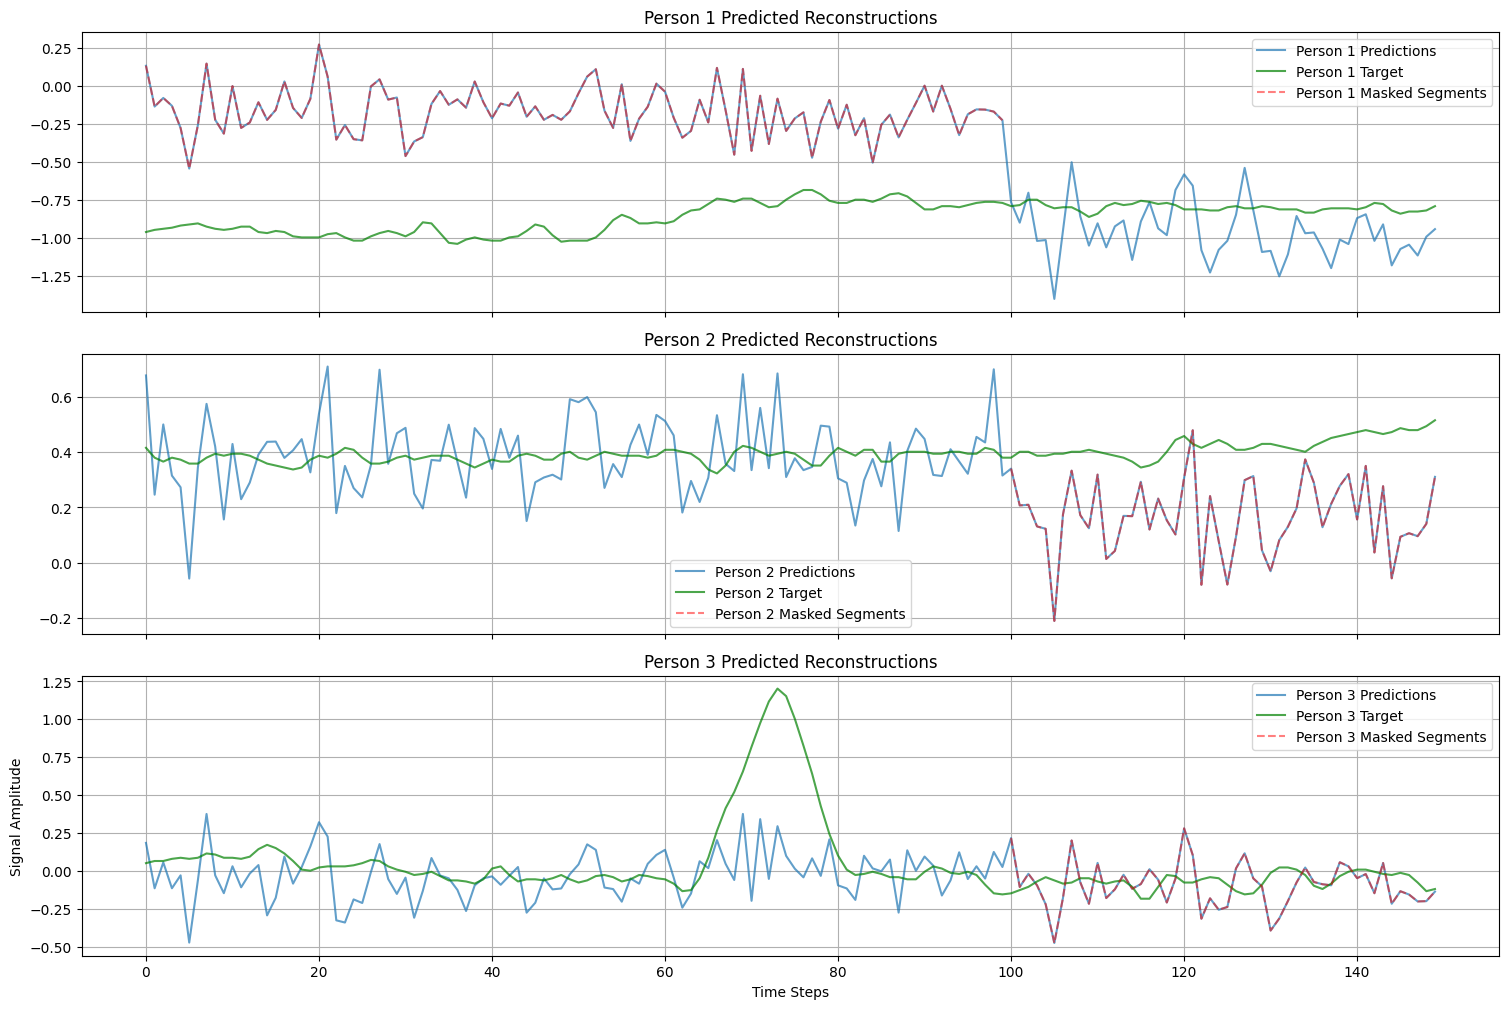

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming predictions and mask are available as PyTorch tensors
# predictions = torch.randn(3, 600, 100, requires_grad=True)  # Example shape
# mask = torch.randint(0, 2, (3, 600), dtype=torch.bool)  # Example mask

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)

target = model_mae.patchify(imgs)

for i in range(3):
    # Flatten the predictions for easier plotting
    flattened_predictions = pred[i].detach().numpy().flatten()
    flattened_target = target[i].numpy().flatten()

    # Create an array to indicate masked segments
    print("mask.shape", mask.shape)
    masked_segments = mask[i].repeat_interleave(100).numpy()

    # Ensure both arrays have the same length
    #length = min(len(flattened_predictions), len(masked_segments), len(flattened_target))
    flattened_predictions = flattened_predictions
    masked_segments = masked_segments
    flattened_target = flattened_target

    # Plot the predictions
    axes[i].plot(flattened_predictions[:150], label=f'Person {i+1} Predictions', alpha=0.7)

    # Plot the target
    axes[i].plot(flattened_target[:150], label=f'Person {i+1} Target', alpha=0.7, color='green')

    # Highlight the masked segments
    axes[i].plot(np.where(masked_segments[:150], flattened_predictions[:150], np.nan),
                 label=f'Person {i+1} Masked Segments', alpha=0.5, color='red', linestyle='--')

    axes[i].set_title(f'Person {i+1} Predicted Reconstructions')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.xlabel('Time Steps')
plt.ylabel('Signal Amplitude')
plt.show()


IndexError: index 1 is out of bounds for dimension 0 with size 1

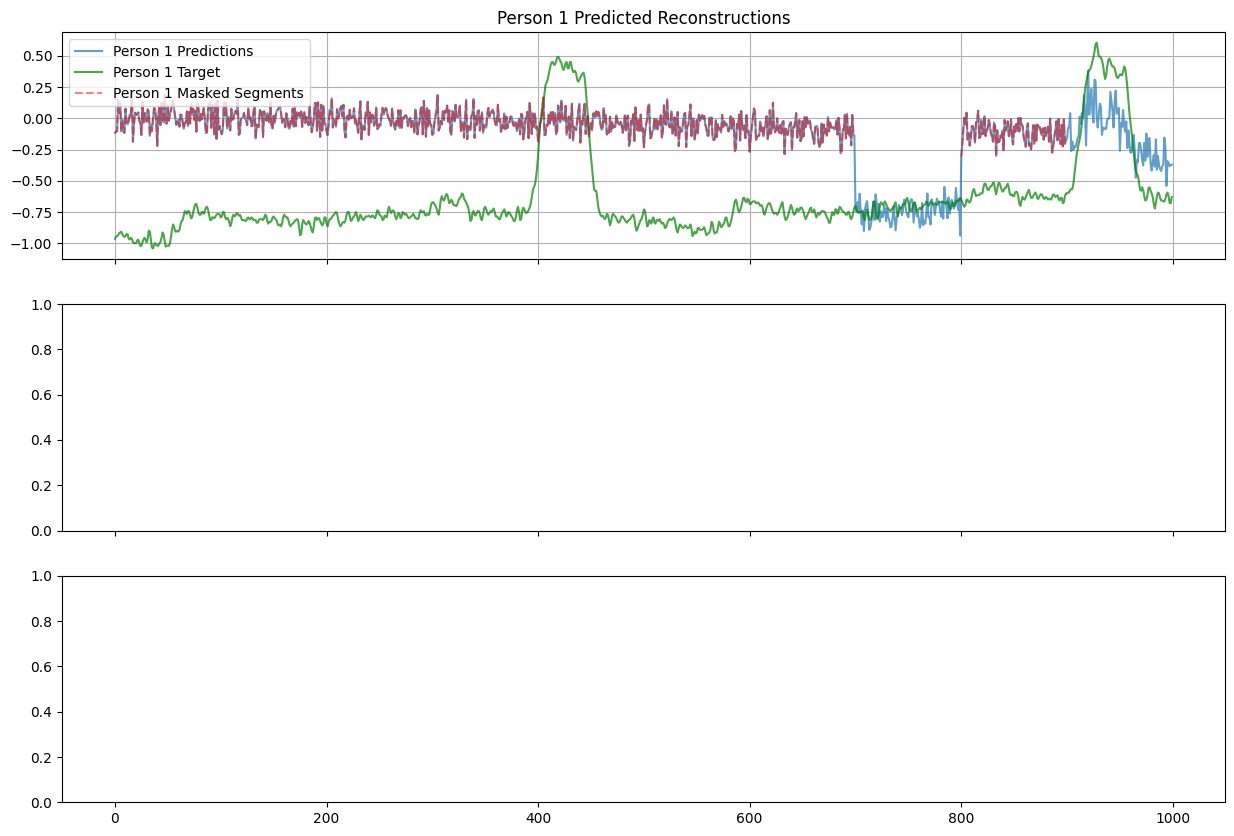

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming predictions, mask, and target are available as PyTorch tensors
# predictions = torch.randn(3, 600, 100, requires_grad=True)  # Example shape
# mask = torch.randint(0, 2, (3, 600), dtype=torch.bool)  # Example mask
# target = torch.randn(3, 600, 100)  # Example target

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)

for i in range(3):
    # Flatten the predictions and target for easier plotting
    flattened_predictions = pred[i].detach().numpy().flatten()
    flattened_target = target[i].numpy().flatten()

    # Create an array to indicate masked segments
    masked_segments = mask[i].repeat_interleave(100).numpy()

    # Ensure all arrays have the same length
    length = min(len(flattened_predictions), len(masked_segments), len(flattened_target))
    flattened_predictions = flattened_predictions[:length]
    masked_segments = masked_segments[:length]
    flattened_target = flattened_target[:length]

    # Plot the predictions
    axes[i].plot(flattened_predictions[:1000], label=f'Person {i+1} Predictions', alpha=0.7)

    # Plot the target
    axes[i].plot(flattened_target[:1000], label=f'Person {i+1} Target', alpha=0.7, color='green')

    # Highlight the masked segments
    axes[i].plot(np.where(masked_segments[:1000], flattened_predictions[:1000], np.nan),
                 label=f'Person {i+1} Masked Segments', alpha=0.5, color='red', linestyle='--')

    axes[i].set_title(f'Person {i+1} Predicted Reconstructions')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.xlabel('Time Steps')
plt.ylabel('Signal Amplitude')
plt.show()


torch.Size([3, 600, 100])


/scratch-local/abujalancegome.10274085/ipykernel_773525/4029066849.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


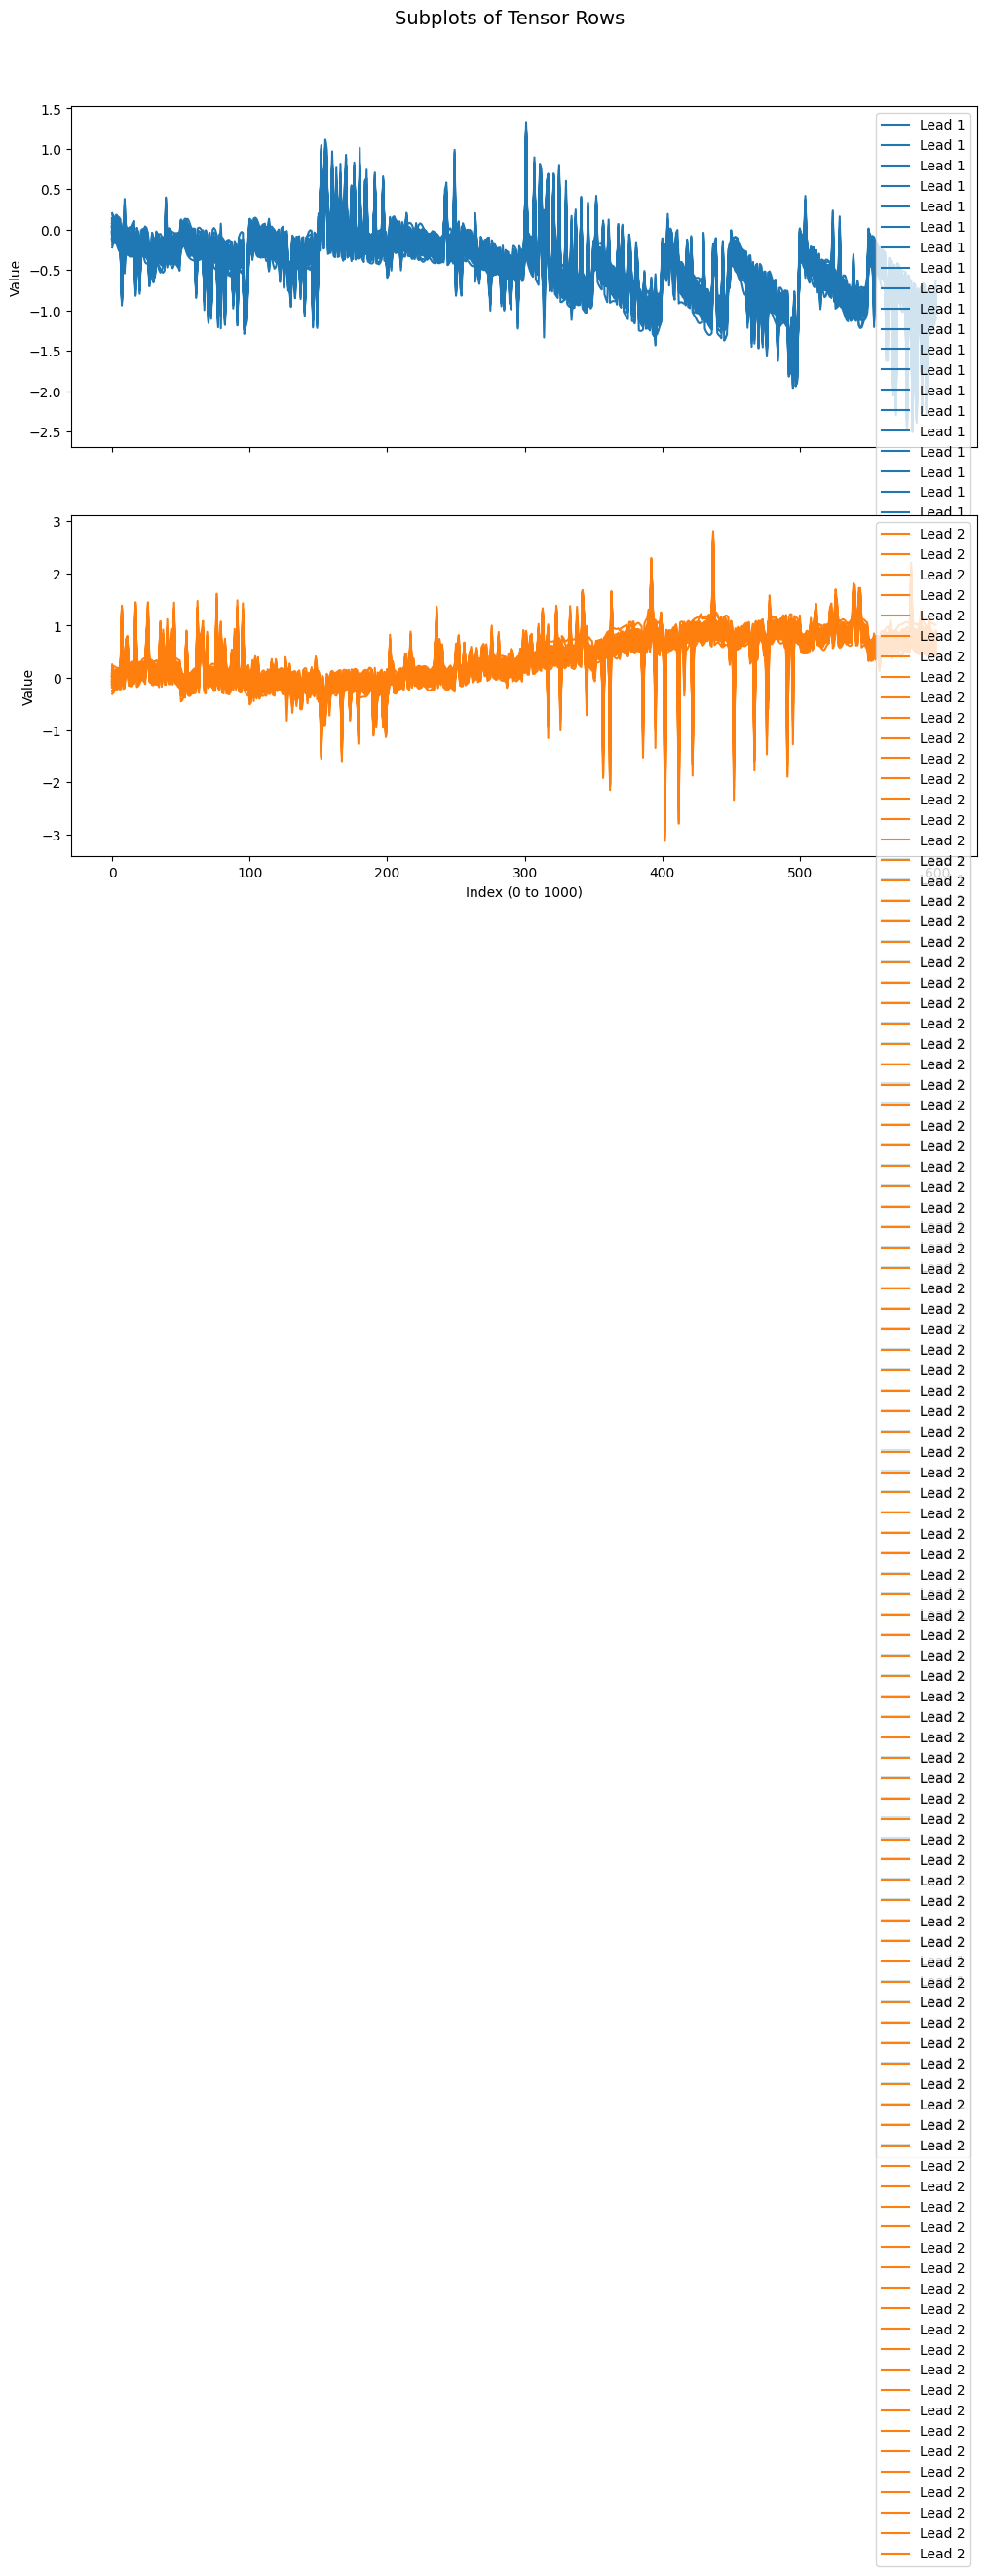

In [8]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

pred_np = pred.detach().numpy() 
print(pred.shape)
for i in range(2):
    axes[i].plot(pred_np[i], label=f"Lead {i+1}", color="C" + str(i))
    axes[i].legend(loc="upper right")
    axes[i].set_ylabel("Value")

axes[-1].set_xlabel("Index (0 to 1000)")
fig.suptitle("Subplots of Tensor Rows", fontsize=14)

plt.tight_layout()
plt.show()

In [9]:
model = model_mae
y = pred
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()
print(y.shape)

print(type(mask))
print(mask.shape)
      #self.patch_embed.patch_size
print(model.patch_embed.patch_size)
print(model.patch_embed.patch_size[0]**2 *3)
# visualize the mask
mask = mask.detach()
mask = mask.repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', tensor)

# masked image
im_masked = x * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(y[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")

plt.show()

torch.Size([3, 12, 5000, 1])
<class 'torch.Tensor'>
torch.Size([3, 600])
(1, 100)
3


AssertionError: 